In [1]:
import pandas as pd
import numpy as np
import pylab as py
import matplotlib.pyplot as plt
import seaborn as sns
import re



In [2]:
pwd


'C:\\Users\\sapfi\\Documents\\7-semestr\\AI System\\sem'

In [4]:
df=pd.read_csv("./wine/winemag-data-130k-v2.csv")
df=df.iloc[:,1:]
df.head()



,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
df1 = df.drop(['description', 'designation',"province",  "region_1", 'region_2', 'taster_name', 'taster_twitter_handle'], axis="columns")

df1.head()




,country,points,price,title,variety,winery
0,Italy,87,NaN,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,87,15.0,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,87,13.0,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,87,65.0,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [6]:
df1.isnull().sum()


country      63
points        0
price      8996
title         0
variety       1
winery        0
dtype: int64

c:\users\sapfi\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sapfi\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


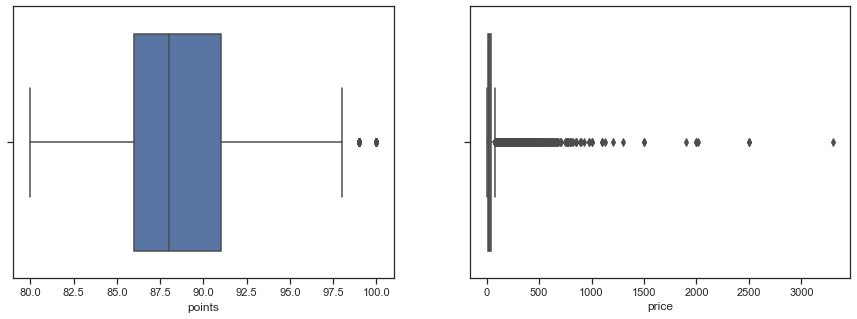

In [8]:



num_data=pd.DataFrame(df1.dtypes[df1.dtypes!="object"]).index

count = 0
fig, ax =plt.subplots(nrows=1,ncols=2, figsize=(15,5))
sns.boxplot(df1[num_data[0]],ax=ax[0])
sns.boxplot(df1[num_data[1]],ax=ax[1]);

Подготовим данные:

In [35]:
yearSearch = []    
for value in df1['title']:
    regexresult = re.search(r'19\d{2}|20\d{2}', value)
    if regexresult:
        yearSearch.append(regexresult.group())
    else: yearSearch.append(None)

df1['year'] = yearSearch
# уберем описание, в тех строчках, где нет года

df1['year']=df1.year.fillna("Unknown")
df2 = df1.drop(['title'], axis="columns")

In [36]:
df2 = df2.dropna(subset=["variety"])
df2.year = df2.year.apply(lambda x: x.strip())
year_stats = df2.groupby("year")["year"].agg("count").sort_values(ascending=False)
df2.variety = df2.variety.apply(lambda x: x.strip())

variety_stats = df2.groupby("variety")["variety"].agg("count").sort_values(ascending=False)
variety_stats_less_than_10 = variety_stats[variety_stats <=10]


df2.winery = df2.winery.apply(lambda x: x.strip())

winery_stats = df2.groupby("winery")["winery"].agg("count").sort_values(ascending=False)

winery_stats_less_than_10 = winery_stats[winery_stats <=10]

df2 = df2.dropna(subset=["variety"])
df2.winery = df2.winery.apply(lambda x :"other_winery" if x in winery_stats_less_than_10 else x)
len(df2.winery.unique())
df3=df2.copy()
from sklearn.impute import KNNImputer
knn_imputer=KNNImputer()
df3.price=knn_imputer.fit_transform(df3[["price"]])
data_final= df3.copy()
data_final.head(10)
feature_cols = ["country", "points", "variety","winery", "year"]

y = data_final.price # Target variable

dummy = data_final[feature_cols] 

X_dummy = pd.get_dummies(dummy, prefix="", prefix_sep="", drop_first=True)

X_dummy.head()

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
ls = Lasso(alpha=0.01).fit(X_dummy, y)
model = SelectFromModel(ls, prefit=True)
X_lasso =[column for column in X_dummy.columns if column not in X_dummy.columns[model.get_support()]]
X =X_dummy.drop(X_lasso, axis=1)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Протестим на моделях:

In [38]:
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
# Define the model
rf_model = RandomForestRegressor(random_state = 1)
# fit model
rf_model.fit(X_train, y_train)
val_predictions = rf_model.predict(X_test)


rf_model.score(X_test,y_test)

0.3141083787169846

In [26]:
def predict_price(country, variety, year, points):    
    loc_index = np.where(X_dummy.columns==country)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = points
    
    if loc_index >= 0:
        x[loc_index] = 1
    
    veriety_index = np.where(X.columns==variety)[0][0]
    if veriety_index >= 0:
        x[veriety_index] = 1
    
    year_index = np.where(X.columns==year)[0][0]
    if year_index >= 0:
        x[year_index] = 1
    
           
    return rf_model.predict([x])[0]

In [27]:
predict_price("Italy","Sangiovese","2015", 78)


12.446663934084224

In [28]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
val_predictions = lr.predict(X_test)

lr_mae = mean_absolute_error(val_predictions, y_test)
R_squ = lr.score(X_test,y_test)


print("R2 for LinearRegression Model: {:.2f}".format(R_squ))
print("Validation MAE for LinearRegression Model: {:.1f}".format(lr_mae))

R2 for LinearRegression Model: 0.27
Validation MAE for LinearRegression Model: 14.9


In [32]:
lr.score(X_test,y_test)


0.2739198005259089

In [33]:
rf_model.score(X_test,y_test)

0.3141083787169846

In [39]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def calc_error(y_res, y_predict):
    acc =  accuracy_score(y_res, y_predict)
    print('Правильность:', acc)
    rec_w = recall_score(y_res, y_predict, average='weighted')
    print('Точность взвешенная:', prec_w)
    prec_m = precision_score(y_res, y_predict, average='macro')
    print('Точность глобальная:', prec_m)
    f1 = f1_score(y_res, y_predict, average='macro')
    print('f1 score:', f1)
    return acc, rec_w, rec_m, prec_w, prec_m, f1
    

In [44]:
table_data = []

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

classes = list(df['description'].unique())
class_count = len(classes)

model = KNeighborsClassifier(n_neighbors=class_count)
model.fit(X_train, y_train)
table_data.append(('KNeighbors', calc_error(y_test, model.predict(X_test))))

ValueError: Unknown label type: 'continuous'